### <b>reproduce FLH retrieval for OCI</b>
To test whether Rrs spectra have different fingerprint for pixels with high and low nFLH

In [1]:
import numpy as np
import xarray as xr
# import dask.array as da
# from dask.distributed import Client, LocalCluster

import earthaccess
from functools import partial
import statsmodels.api as sm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

auth = earthaccess.login()

In [2]:
# select a granule for testing
num_of_chunks = 10
granule = earthaccess.open(
    granules = ["https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250501T183011.L1B.V3.nc"]
)

# L2 data
granule = earthaccess.open(
    granules = ["https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250501T183011.L2.OC_AOP.V3_1.nc"]
)
# name2 = "/home/zhe2/data/PACE/L2_AOP/PACE_OCI.20250130T204559.L2.OC_AOP.V3_0.nc"
datatree2 = xr.open_datatree(granule[0])
ds2 = xr.merge(datatree2.to_dict().values())
ds2

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset> Size: 3GB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 172, number_of_lines: 1710,
                    pixels_per_line: 1272)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 1kB 346.0 348.0 351.0 ... 717.0 719.0
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/32)
    wavelength     (number_of_bands) float64 2kB ...
    vcal_gain      (number_of_reflective_bands) float32 1kB ...
    vcal_offset    (number_of_reflective_bands) float32 1kB ...
    F0             (number_of_reflective_bands) float32 1kB ...
    aw             (number_of_reflective_bands) float32 1kB ...
    bbw            (number_of_reflective_bands) float32 1kB ...
    ...             ...
    avw            (number_of_lines, pixels_per_line) float32 9MB ...
    nflh           (number_of_lines, pixels_per_line) float32 9MB ...
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB ...
    longitude      (number_of_lines, pixels_per_line) float32 9MB ...
    latitude       (number_of_lines, pixels_per_line) float32 9MB ...
    tilt           (number_of_lines) float32 7kB ...
Attributes: (12/47)
    title:                             OCI Level-2 Data AOP
    product_name:                      PACE_OCI.20250501T183011.L2.OC_AOP.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data1/sdpsoper/vdc/vpu20/wo...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                -105.20019
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9847794771194458
    geospatial_bounds:                 POLYGON ((-74.89859 41.61203, -105.200...

In [3]:
# subset ds2 to: 1) select some variables; 2) align wavelength range!
wavelength_3d = ds2.wavelength_3d.values
wavelength    = ds2.wavelength.values
index         = np.isin(wavelength, wavelength_3d)
ds2_sub       = ds2.isel(number_of_bands=index, number_of_reflective_bands=index)

# squeeze
ds2_sub = ds2_sub.rename({'number_of_bands': 'wavelength_3d', 
                'number_of_reflective_bands': 'wavelength_3d'
                }).squeeze()

print("squeezed!")

squeezed!


### <b>Choose low-nFLH pixels as baseline & high-nFLH for comparison?</b>

In [5]:
mask1 = ds2_sub['nflh'] < 0.01
lns1, pxs1 = np.where(mask1.values)

mask2 = ds2_sub['nflh'] >= 0.3
lns2, pxs2 = np.where(mask2.values)

mask3 = (ds2_sub['nflh'] >= 0.01) & (ds2_sub['nflh'] <= 0.05)
lns3, pxs3 = np.where(mask3.values)

low_nFLH_mat = ds2_sub.Rrs.isel(
    number_of_lines=xr.DataArray(lns1, dims='selected'),
    pixels_per_line=xr.DataArray(pxs1, dims='selected')
)

mid_nFLH_mat = ds2_sub.Rrs.isel(
    number_of_lines=xr.DataArray(lns3, dims='selected'),
    pixels_per_line=xr.DataArray(pxs3, dims='selected')
)

high_nFLH_mat = ds2_sub.Rrs.isel(
    number_of_lines=xr.DataArray(lns2, dims='selected'),
    pixels_per_line=xr.DataArray(pxs2, dims='selected')
)

In [10]:
# add attribute to this array
mid_nFLH_mat.attrs['description'] = 'Rrs for low nFLH (0.01 - 0.05)'
# save to netcdf
file_dir = "/home/zhe2/data/MyProjects/PACE_redSIF_PACE/sample/"
mid_nFLH_mat.to_netcdf(file_dir + "PACE_OCI_L2_Rrs_mid_nFLH.nc")

Text(0.5, 1.0, 'Mid nFLH (0.01 - 0.05)')

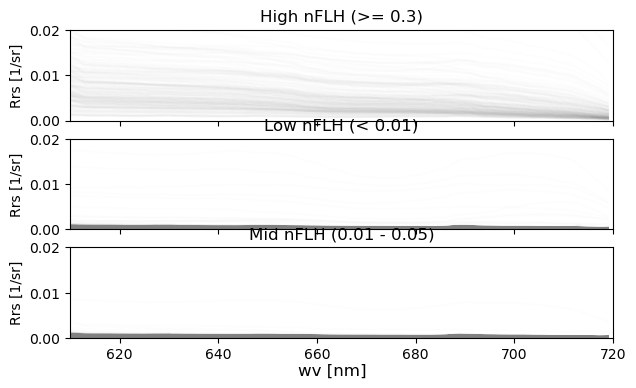

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(7,4), sharex=True, sharey=True)

ax[0].plot(wavelength_3d, high_nFLH_mat[::100,].transpose(), color='gray', alpha=0.01)
ax[1].plot(wavelength_3d, low_nFLH_mat[::100,].transpose(), color='gray', alpha=0.01)
ax[2].plot(wavelength_3d, mid_nFLH_mat[::100,].transpose(), color='gray', alpha=0.01)

ax[0].set_ylim(0, 0.02)
ax[2].set_xlim(610, 720)

fig.supxlabel("wv [nm]")
ax[0].set_ylabel("Rrs [1/sr]")
ax[1].set_ylabel("Rrs [1/sr]")
ax[2].set_ylabel("Rrs [1/sr]")

# title
ax[0].set_title("High nFLH (>= 0.3)")
ax[1].set_title("Low nFLH (< 0.01)")
ax[2].set_title("Mid nFLH (0.01 - 0.05)")

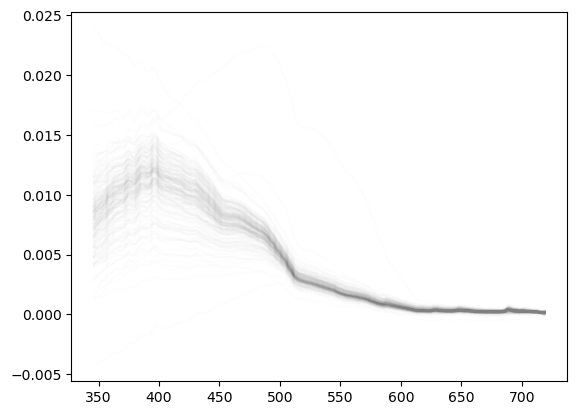

In [32]:
plt.plot(wavelength_3d, low_nFLH_mat[::1000,].transpose(), color='gray', alpha=0.01)

### <b>Take average?</b>

In [10]:
high_nFLH_avg = high_nFLH_mat.mean(axis=0)
low_nFLH_avg  = low_nFLH_mat.mean(axis=0)

Text(0, 0.5, 'Rrs [1/sr]')

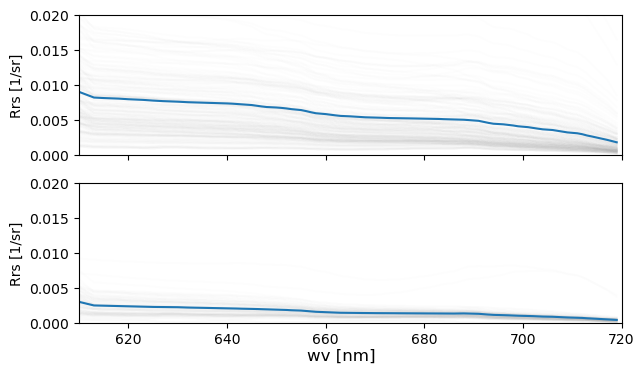

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(7,4), sharex=True, sharey=True)
ax[0].plot(wavelength_3d, high_nFLH_mat[::100,].transpose(), color='gray', alpha=0.01)
ax[0].plot(wavelength_3d, high_nFLH_avg)
ax[1].plot(wavelength_3d, low_nFLH_mat[::100,].transpose(), color='gray', alpha=0.01)
ax[1].plot(wavelength_3d, low_nFLH_avg)

ax[0].set_ylim(0, 0.02)
ax[1].set_xlim(610, 720)

fig.supxlabel("wv [nm]")
ax[0].set_ylabel("Rrs [1/sr]")
ax[1].set_ylabel("Rrs [1/sr]")
# fig.suptitle(f"select: number_of_lines={lines}, px_per_line={px}")

In [15]:
def find_nearest(arr, trg):
    idx = [np.argmin(np.abs(arr - i)) for i in trg]
    return idx

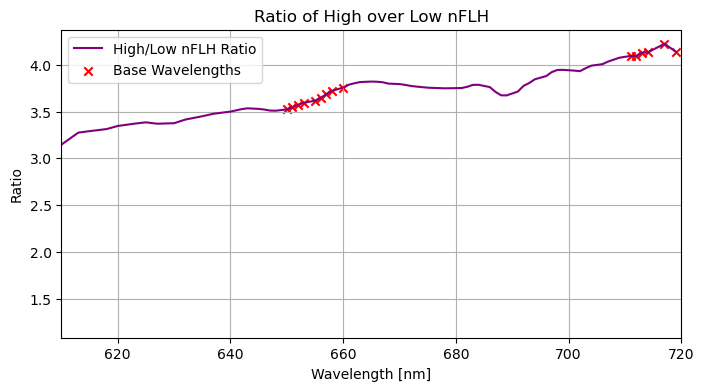

In [16]:
# Calculate the ratio
nFLH_ratio = high_nFLH_avg / low_nFLH_avg

# Plot the ratio
plt.figure(figsize=(8, 4))
plt.plot(wavelength_3d, nFLH_ratio, label='High/Low nFLH Ratio', color='purple')

# Draw crosses at specific wavelengths
base_wv = np.array([649.599976, 650.900024, 652.099976, 653.299988,
                    654.599976, 655.799988, 657.099976, 658.299988,
                    659.599976, 710.500000, 711.799988, 713.000000,
                    714.299988, 716.799988, 719.200012])
base_indices = find_nearest(wavelength_3d, base_wv)
plt.scatter(wavelength_3d[base_indices], nFLH_ratio[base_indices], color='red', marker='x', label='Base Wavelengths')

plt.xlim(610, 720)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Ratio")
plt.title("Ratio of High over Low nFLH")
plt.grid()
plt.legend()
plt.show()

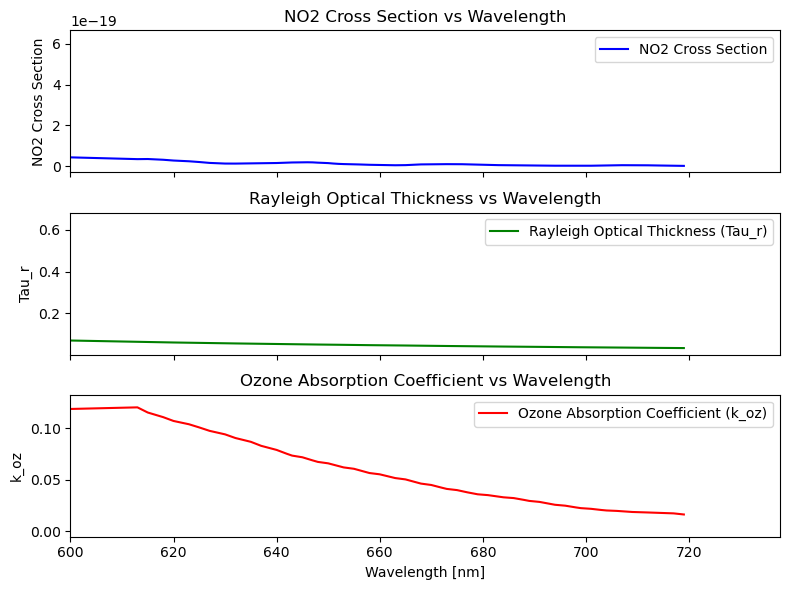

In [57]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

# Plot NO2 Cross Section
ax[0].plot(wavelength_3d, ds2_sub['k_no2'].values, label='NO2 Cross Section', color='blue')
ax[0].set_ylabel("NO2 Cross Section")
ax[0].set_title("NO2 Cross Section vs Wavelength")
ax[0].set_xlim(600, None)
ax[0].legend()

# Plot Tau_r
ax[1].plot(wavelength_3d, ds2_sub['Tau_r'].values, label='Rayleigh Optical Thickness (Tau_r)', color='green')
ax[1].set_ylabel("Tau_r")
ax[1].set_title("Rayleigh Optical Thickness vs Wavelength")
ax[1].legend()

# Plot k_oz
ax[2].plot(wavelength_3d, ds2_sub['k_oz'].values, label='Ozone Absorption Coefficient (k_oz)', color='red')
ax[2].set_xlabel("Wavelength [nm]")
ax[2].set_ylabel("k_oz")
ax[2].set_title("Ozone Absorption Coefficient vs Wavelength")
ax[2].legend()

plt.tight_layout()
plt.show()